Load in the weather, smartmeter and gasmeter data as 3 seperate dataframes. 
Goal is to combine them into one dataframe.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

def load_data():
    global smart
    global gas
    global weather
    df =pd.read_csv("/datc/opschaler/smartmeter_data/P01S01W0373.csv",header=0,delimiter=";",parse_dates=['Timestamp', 'gasTimestamp'])

    # Split the smartmeter and gasmeter data
    smart = df.iloc[:,:7]
    gas = df.iloc[:, 7:]
    
    #Read in weather data
    weather_path = "//datc//opschaler//weather_data//20170101to20180101.txt"
    weather_column_names = ['STN','YYYYMMDD','HH','DD','FH','FF','FX','T','T10','TD','SQ','Q','DR','RH','P','VV','N','U','WW','IX','M','R','S','O','Y']

    weather = pd.read_csv(weather_path, delimiter=',', comment='#', names=weather_column_names, parse_dates=['YYYYMMDD', 'HH'])
    weather['T'] = weather['T']*0.1 # Convert temperature to celcius instead of 0.1 celcius
    weather['HH'] = weather['HH']+':00:00'
    weather['HH'] = weather['HH'].str.strip() # removes the blank spaces infront of the strings
    weather['HH'] = weather['HH'].str.replace('24:00:00', '23:59:59') # KNMI uses 24 for 00 hours.... to have to convert this for to_datetime to be able to work
    weather.loc[:,'datetime'] = pd.to_datetime(weather['YYYYMMDD'].astype(str)+' '+weather['HH'].astype(str)) #create datetime column

In [19]:
"""
Problem: How to merge 3 frames with 3 different datetime's?
The format is the same, but they don't have ''exact'' matches with each other. 
i.e. 

"""
load_data()
# Change all datetime columns to the same column name
smart = smart.rename(index=str, columns={"Timestamp":"datetime"})
gas = gas.rename(index=str, columns={"gasTimestamp":"datetime"})


#df = df[['datetime', 'eMeter', 'eMeterLow', 'ePower', 'gasMeter', 'T', 'Q']]
#df = df[['datetime', 'eMeter', 'eMeterLow', 'ePower', 'gasMeter']]
smart.head()

del weather['STN'], weather['HH'], weather['YYYYMMDD']

# Set datetime as index
weather = weather.set_index(['datetime'])
smart = smart.set_index(['datetime'])
gas = gas.set_index(['datetime'])

In [20]:
"""
Resample the dataframes to 10s intervals.
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
"""
weather = weather.resample('10s').interpolate(method='time')
smart = smart.resample('10s').mean()

# gas contains duplicates, they need to be removed
#gas = gas.drop_duplicates()
gas = gas.resample('H').mean() # Does not look nice, but it works

# Create a ''gasPower'' column. This equals the gas used in that hour
gas['gasPower'] = gas['gasMeter'].diff()
# First entry is NaN, replace NaN by second entry
gas['gasPower'][0] = gas['gasPower'][1]
gas = gas.resample('10s').interpolate(method='time')

In [21]:
df = pd.merge(smart, weather,left_index=True, right_index=True)
df = pd.merge(df, gas,left_index=True, right_index=True)
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,DD,FH,FF,FX,...,U,WW,IX,M,R,S,O,Y,gasMeter,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 18:14:20,3717.472,0.0,3883.382,0.0,376.0,0.0,255.222222,30.0,32.388889,60.0,...,81.761111,NaN,5.0,0.0,0.0,0.0,0.0,0.0,1599.838344,0.194
2017-03-07 18:14:30,3717.473,0.0,3883.382,0.0,381.0,0.0,255.166667,30.0,32.416667,60.0,...,81.758333,NaN,5.0,0.0,0.0,0.0,0.0,0.0,1599.838883,0.194
2017-03-07 18:14:40,3717.474,0.0,3883.382,0.0,378.0,0.0,255.111111,30.0,32.444444,60.0,...,81.755556,NaN,5.0,0.0,0.0,0.0,0.0,0.0,1599.839422,0.194
2017-03-07 18:14:50,3717.475,0.0,3883.382,0.0,376.0,0.0,255.055556,30.0,32.472222,60.0,...,81.752778,NaN,5.0,0.0,0.0,0.0,0.0,0.0,1599.839961,0.194
2017-03-07 18:15:00,3717.476,0.0,3883.382,0.0,380.0,0.0,255.000000,30.0,32.500000,60.0,...,81.750000,NaN,5.0,0.0,0.0,0.0,0.0,0.0,1599.840500,0.194


<IPython.core.display.Javascript object>


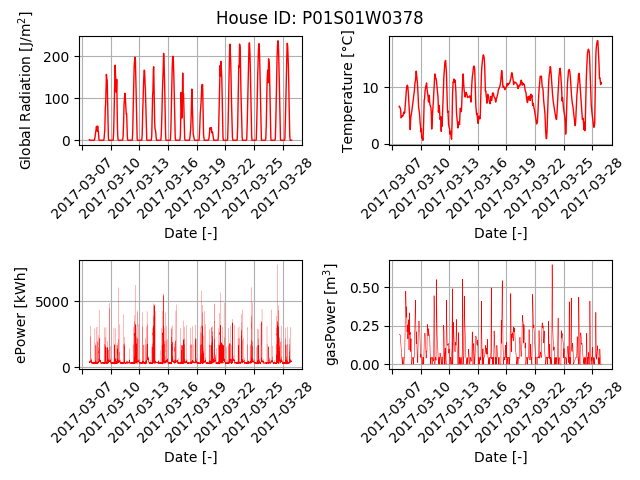

In [22]:
plt.suptitle('House ID: P01S01W0378')

plt.subplot(2,2,1)
plt.plot(df.index, df['Q'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,2)
plt.plot(df.index, df['T'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Temperature [°C]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(df.index, df['ePower'], '-', color='r', linewidth=0.1)
plt.xlabel('Date [-]')
plt.ylabel('ePower [kWh]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,4)
plt.plot(df.index, df['gasPower'], '-', color='r', linewidth=0.4)
plt.xlabel('Date [-]')
plt.ylabel('gasPower [m$^3$]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


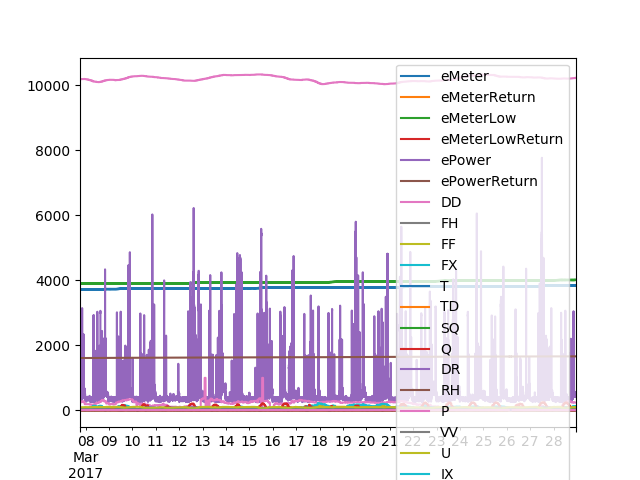

In [6]:
df.plot()

In [7]:
df.shape

(183155, 30)

In [8]:
#df.to_csv('//datc//opschaler//output//P01S01W0378_gas_electricity_weather.csv', sep='\t', index=False)

<IPython.core.display.Javascript object>


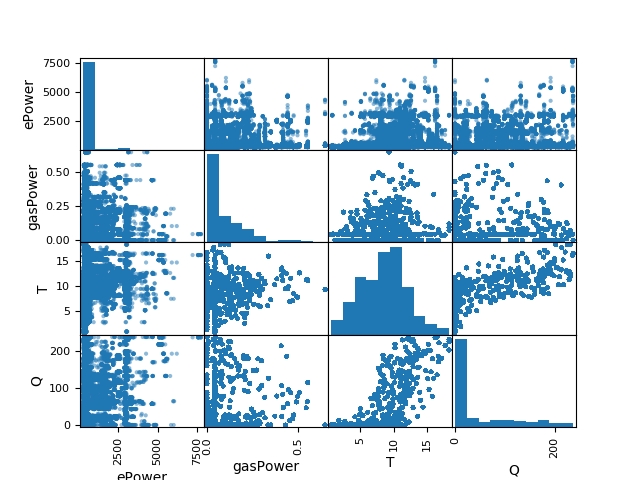

In [9]:
"""
Only keep relevant information for scrumwise sprint 2.
-> smartmeter energy usage data
-> gasmeter gas usage data
-> outside temperature
-> global radiation
"""

df = df[['ePower','gasPower','T','Q']]
_ = pd.plotting.scatter_matrix(df)

<IPython.core.display.Javascript object>


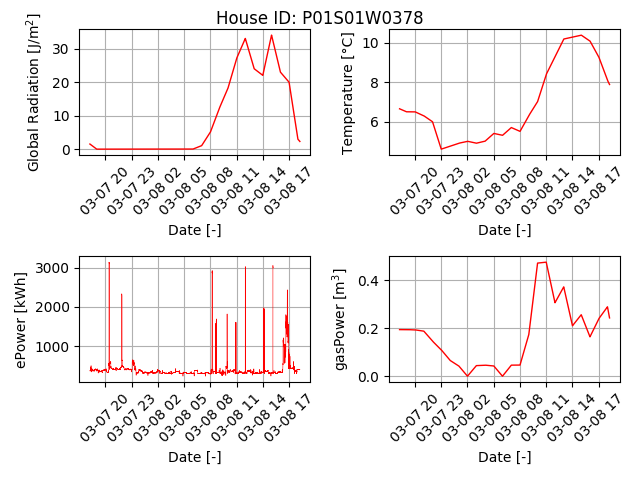

In [25]:
# t as in, test dataframe. 1*24*6*60 is equal the the data of one day.
t = df.iloc[:1*24*6*60,:]

plt.suptitle('House ID: P01S01W0378')

plt.subplot(2,2,1)
plt.plot(t.index, t['Q'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,2)
plt.plot(t.index, t['T'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Temperature [°C]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(t.index, t['ePower'], '-', color='r', linewidth=0.4)
plt.xlabel('Date [-]')
plt.ylabel('ePower [kWh]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,4)
plt.plot(t.index, t['gasPower'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('gasPower [m$^3$]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


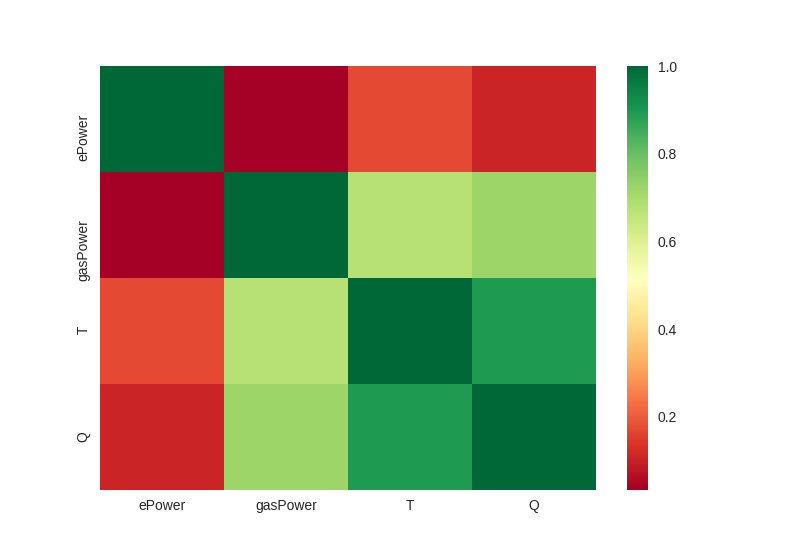

In [11]:
"""
Plot a correlation heatmap.
Cells that are in green show positive correlation, while cells that are in red show negative correlation.
Learned from: https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/regression-2?ex=4

-> seems to give higher correlation on smaller timescales (<day).
"""
import seaborn as sns
#df = df[['ePower','gasPower','T','Q']]

sns.heatmap(t.corr(), square=False, cmap='RdYlGn')

In [12]:
# time it example
# %timeit code_or_function_here
%timeit None

100000000 loops, best of 3: 6.48 ns per loop


In [13]:
df.describe()

,ePower,gasPower,T,Q
count,180212.000000,1.809950e+05,183155.000000,183155.000000
mean,459.073052,1.026101e-01,8.491030,47.618400
std,452.841780,1.114314e-01,3.481666,68.815877
min,238.000000,-9.094947e-13,0.600000,0.000000
25%,319.000000,4.200000e-02,5.800000,0.000000
50%,350.000000,4.600000e-02,8.500000,2.000000
75%,414.000000,1.420000e-01,10.800000,87.000000
max,7765.000000,6.470000e-01,18.300000,237.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183155 entries, 2017-03-07 18:14:20 to 2017-03-28 23:00:00
Freq: 10S
Data columns (total 4 columns):
ePower      180212 non-null float64
gasPower    180995 non-null float64
T           183155 non-null float64
Q           183155 non-null int64
dtypes: float64(3), int64(1)
memory usage: 7.0 MB
